In [146]:
import io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import boxcox
from scipy.stats import skewtest

import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import requests

# 1. Feature Encoding/Transformation and EDA:

In [147]:
url = 'https://storage.googleapis.com/cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv'
res = requests.get(url, proxies = {'https': 'http://165.225.80.40:443'})
df_raw = pd.read_csv(io.StringIO(res.text))
df_raw.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,Yes
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes


In [148]:
columns = ['Type', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Adopted']
df = df_raw.copy()
encoder_mappings = {}
encoder_mappings['Adopted'] = {'Yes': 1, 'No': 0}
for col in columns:
    encoder_mappings[col] =  {val: i for i, val in enumerate(df[col].unique())}
    df[col] = df[col].map(encoder_mappings[col])
df

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,0,3,0,0,0,0,0,0,0,0,0,100,1,0
1,0,1,1,0,0,1,1,1,1,1,0,0,2,0
2,1,1,2,0,1,0,1,1,2,0,0,0,7,0
3,1,4,2,1,0,1,1,0,2,0,0,150,8,0
4,1,1,2,0,0,2,1,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,1,24,28,0,1,5,1,1,1,0,0,0,0,1
11533,0,1,3,1,2,3,1,0,0,0,0,0,1,0
11534,1,6,14,1,0,0,0,2,2,0,0,0,1,0
11535,0,9,3,1,6,0,0,0,2,2,0,0,3,1


In [149]:
# column_transformer = ColumnTransformer(
#     transformers=[
#         ('ordinal', OrdinalEncoder(), ['Breed1', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Type', 'Gender','Adopted']),
#         # ('onehot', OneHotEncoder(sparse_output=False), ['Color1',])
#     ],
#     remainder='passthrough'  # Keep the rest of the columns unchanged
# ).set_output(transform='pandas')

# pipeline = Pipeline(steps=[
#     ('preprocessor', column_transformer)
# ])
# df = pipeline.fit_transform(df_raw)

In [150]:
df.isnull().sum()

Type            0
Age             0
Breed1          0
Gender          0
Color1          0
Color2          0
MaturitySize    0
FurLength       0
Vaccinated      0
Sterilized      0
Health          0
Fee             0
PhotoAmt        0
Adopted         0
dtype: int64

there seems to be no missing values.

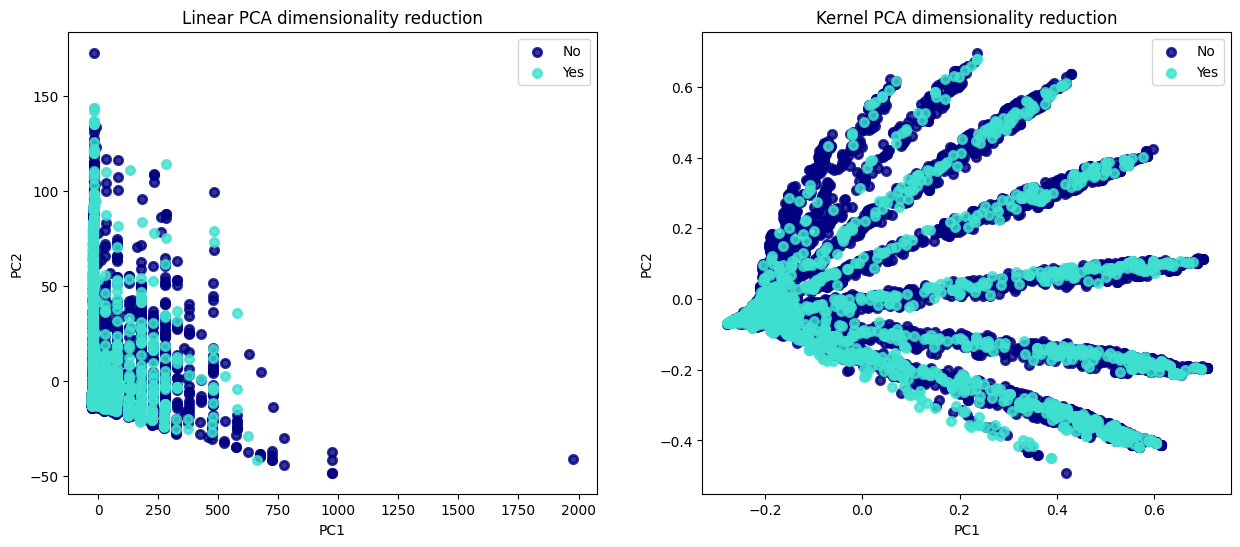

In [151]:
pca = PCA(n_components=2)
kpca = KernelPCA(n_components=2, kernel='rbf')

X_pca = pca.fit_transform(df.drop(['Adopted'], axis=1))
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

X_kpca = kpca.fit_transform(df.drop(['Adopted'], axis=1))
kpca_df = pd.DataFrame(X_kpca, columns=['PC1', 'PC2'])

pca_df['class'] = df['Adopted']
kpca_df['class'] = df['Adopted']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
colors = ['navy', 'turquoise']
lw = 2

for color, i, target_name in zip(colors, [0, 1], ['No', 'Yes']):
    ax1.scatter(pca_df[pca_df['class'] == i]['PC1'], pca_df[pca_df['class'] == i]['PC2'], color=color, alpha=.8, lw=lw, label=target_name)
    ax1.set_title("Linear PCA dimensionality reduction")
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.legend(loc='best', shadow=False, scatterpoints=1)
    ax2.scatter(kpca_df[kpca_df['class'] == i]['PC1'], kpca_df[kpca_df['class'] == i]['PC2'], color=color, alpha=.8, lw=lw, label=target_name)
    ax2.set_title("Kernel PCA dimensionality reduction")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.legend(loc='best', shadow=False, scatterpoints=1)
# Show the plot
plt.show()

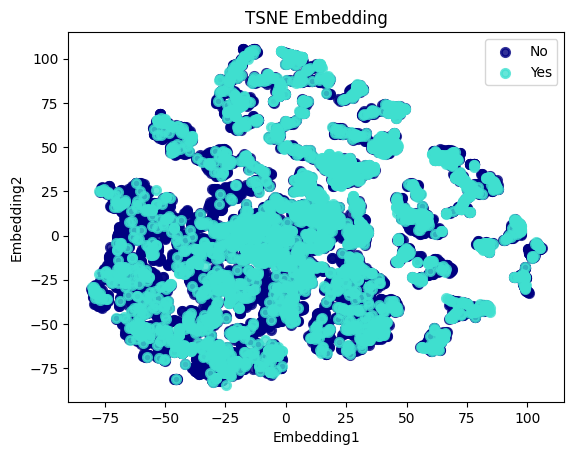

In [152]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(df.drop(['Adopted'], axis=1))
tsne_df = pd.DataFrame(X_tsne, columns=['Embedding1', 'Embedding2'])
tsne_df['class'] = df['Adopted']

fig, ax = plt.subplots()
colors = ['navy', 'turquoise']
lw = 2

for color, i, target_name in zip(colors, [0, 1], ['No', 'Yes']):
    ax.scatter(tsne_df[tsne_df['class'] == i]['Embedding1'], tsne_df[tsne_df['class'] == i]['Embedding2'], color=color, alpha=.8, lw=lw, label=target_name)
ax.set_title("TSNE Embedding")
ax.set_xlabel("Embedding1")
ax.set_ylabel("Embedding2")
ax.legend(loc='best', shadow=False, scatterpoints=1)
# Show the plot
plt.show()


In [153]:
df.describe()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
count,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000
mean,0.572159,11.743434,10.129063,0.560458,1.338736,1.802722,0.875271,0.482794,1.008494,0.583947,0.040652,23.957268,3.610211,0.266967
std,0.494787,19.324221,20.666082,0.496353,1.767674,1.612113,0.538200,0.610447,0.932034,0.842943,0.210247,80.024226,3.145872,0.442394
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,1.000000,4.000000,3.000000,1.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,1.000000,12.000000,5.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,5.000000,1.000000
max,1.000000,255.000000,165.000000,1.000000,6.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2000.000000,30.000000,1.000000


In [154]:
# skewtest p-values:
pd.Series(skewtest(df)[1], index=df.columns)

Type             4.412811e-36
Age              0.000000e+00
Breed1           0.000000e+00
Gender           5.812371e-26
Color1           0.000000e+00
Color2          8.613817e-278
MaturitySize     5.163661e-05
FurLength       1.209947e-244
Vaccinated       4.597081e-01
Sterilized      9.072937e-258
Health           0.000000e+00
Fee              0.000000e+00
PhotoAmt         0.000000e+00
Adopted          0.000000e+00
dtype: float64

looking at the quartiles and other statistics we can deduce that all features suffer from skewness with different degrees of severity, we will perform some transformations on the features to reduce the effect of the skewness.

## Target:

<Axes: xlabel='Adopted'>

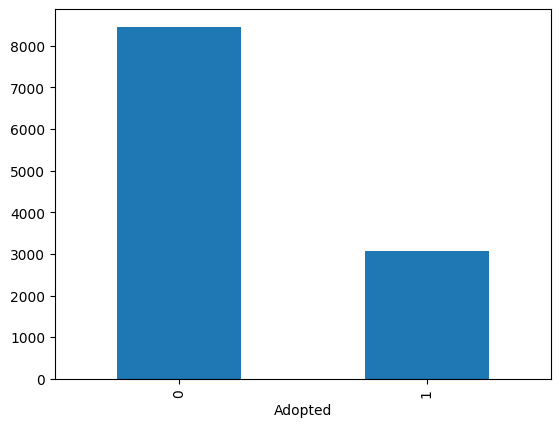

In [155]:
df['Adopted'].value_counts().plot(kind='bar')

## Age:

<Axes: ylabel='Frequency'>

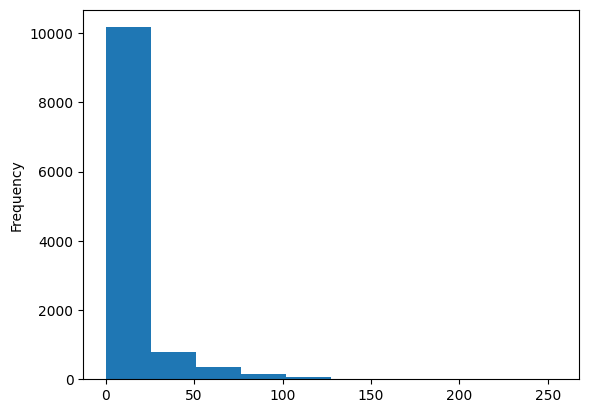

In [156]:
df['Age'].plot(kind='hist')

<Axes: xlabel='Age'>

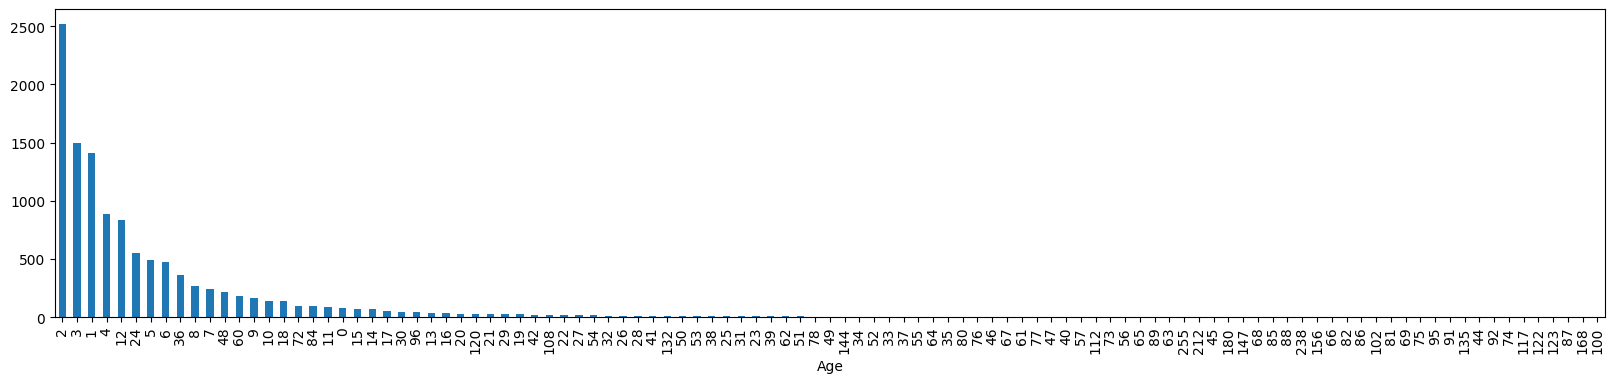

In [157]:
plt.figure(figsize=(20, 4))
df['Age'].value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

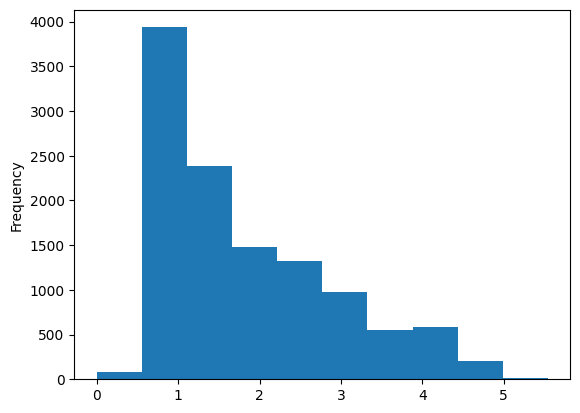

In [158]:
df['Age'] = np.log1p(df['Age'])
# df['Age'] = boxcox(df['Age'] + 1)[0]
df['Age'].plot(kind='hist')

In [159]:
# df['Age'] = pd.qcut(df['Age'], q=4, labels=[1,2,3,4]).astype(int)
# df['Age'].value_counts().plot(kind='bar')

## Breed1:

<Axes: xlabel='Breed1'>

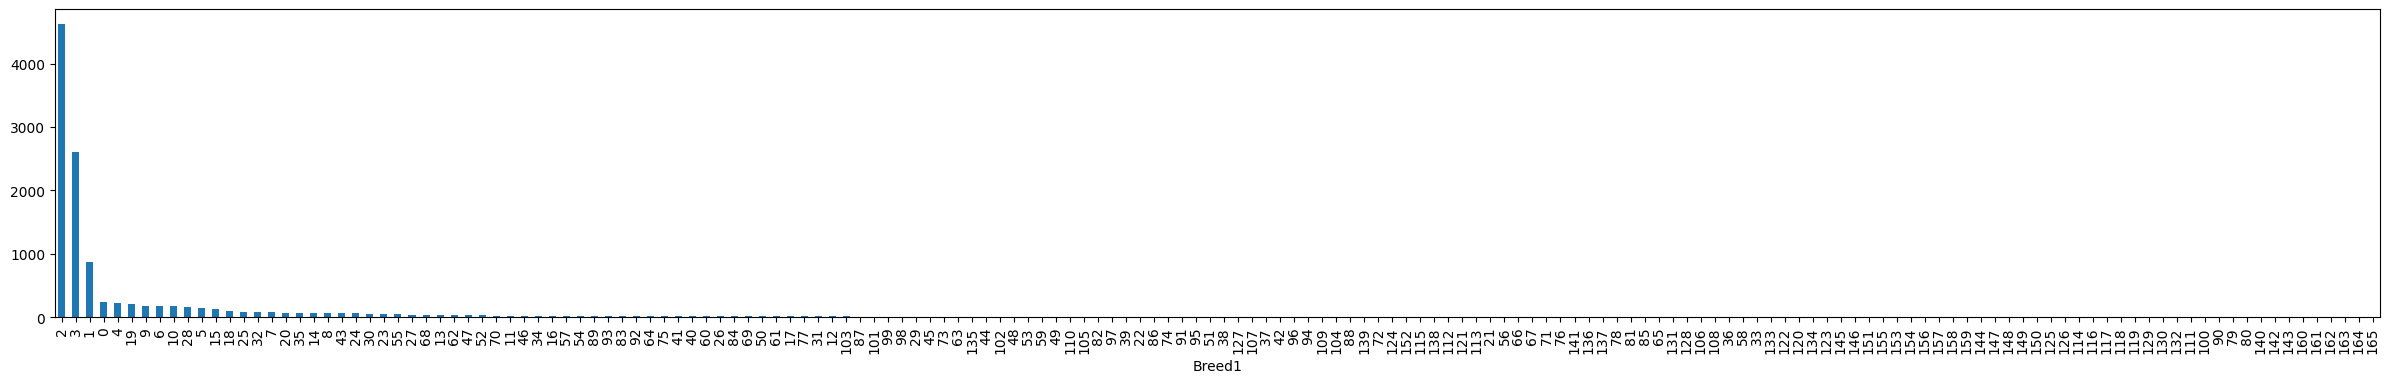

In [160]:
plt.figure(figsize=(30, 4))
df['Breed1'].value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

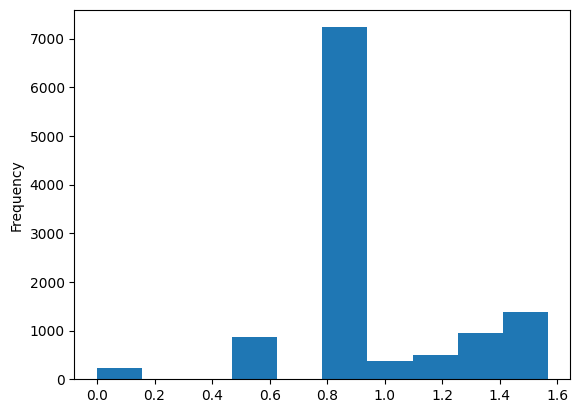

In [161]:
df['Breed1'] = boxcox(df['Breed1'] + 1)[0]
# df['Breed1'] = np.sqrt(df['Breed1'])
# df['Breed1'] = np.log1p(df['Breed1'])
df['Breed1'].plot(kind='hist')

## Fee:

<Axes: ylabel='Frequency'>

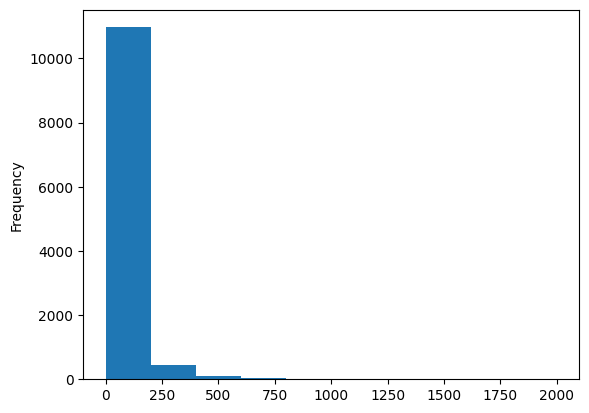

In [162]:
# plt.figure(figsize=(20, 4))
# df['remainder__Fee'].value_counts().plot(kind='bar')
df['Fee'].plot(kind='hist')

<Axes: ylabel='Frequency'>

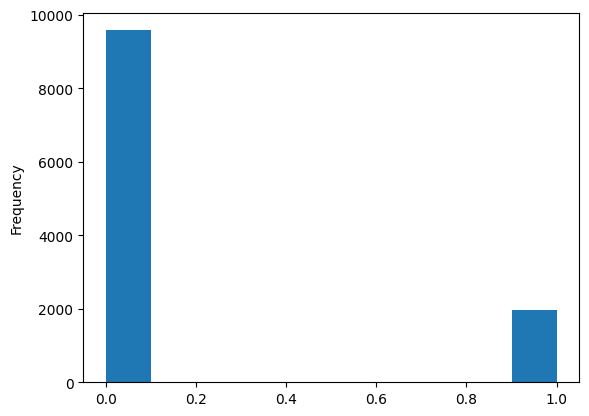

In [163]:
# df['Fee'] = np.log1p(df['Fee'])
df.loc[df['Fee'] > 0, 'Fee'] = 1
df['Fee'].plot(kind='hist')

## PhotoAmt:

<Axes: ylabel='Frequency'>

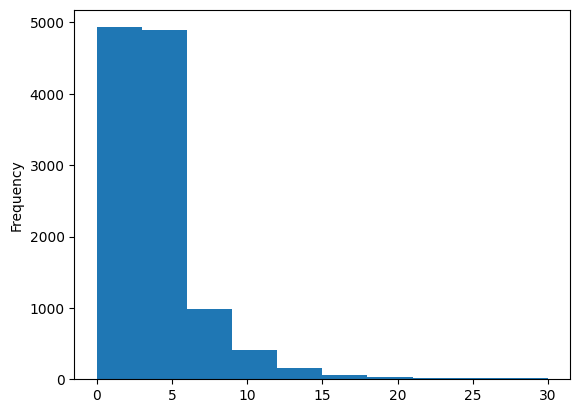

In [164]:
df['PhotoAmt'].plot(kind='hist')

<Axes: xlabel='PhotoAmt'>

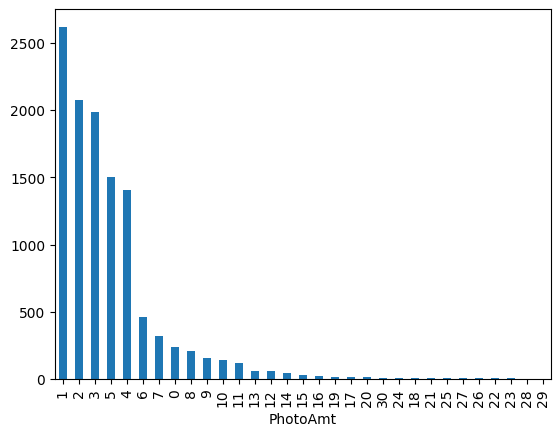

In [165]:
df['PhotoAmt'].value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

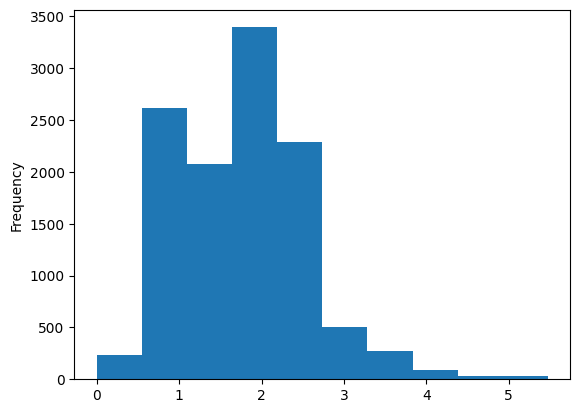

In [166]:
df['PhotoAmt'] = np.sqrt(df['PhotoAmt'])
df['PhotoAmt'].plot(kind='hist')

## Color1:

In [167]:
df_raw['Color1'].unique()

array(['Black', 'Brown', 'Cream', 'Gray', 'Golden', 'White', 'Yellow'],
      dtype=object)

<Axes: xlabel='Color1'>

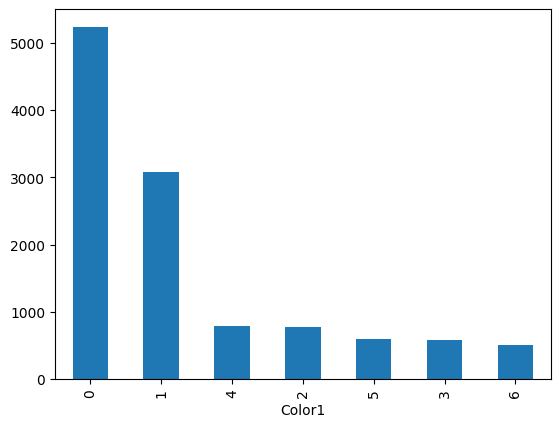

In [168]:
df['Color1'].value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

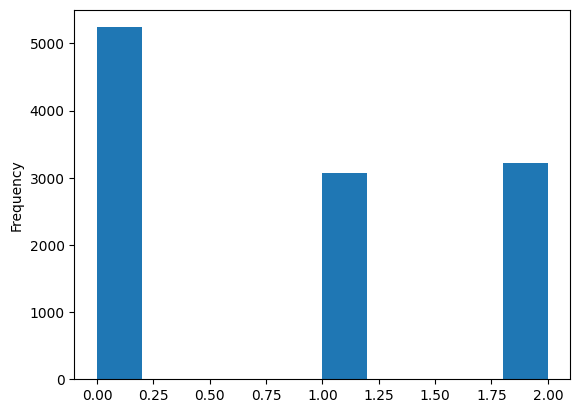

In [169]:
df.loc[df['Color1'] >= 2, 'Color1']= 2
df['Color1'].plot(kind='hist')

## Color2:

In [170]:
df_raw['Color2'].unique()

array(['White', 'Brown', 'No Color', 'Gray', 'Cream', 'Golden', 'Yellow'],
      dtype=object)

<Axes: xlabel='Color2'>

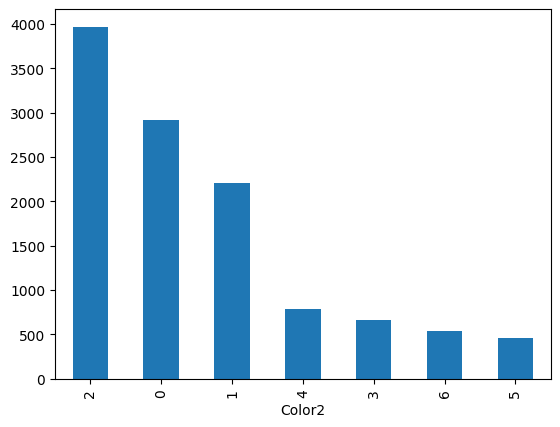

In [171]:
df['Color2'].value_counts().plot(kind='bar')

## MaturitySize:

In [172]:
df_raw['MaturitySize'].unique()

array(['Small', 'Medium', 'Large'], dtype=object)

<Axes: xlabel='MaturitySize'>

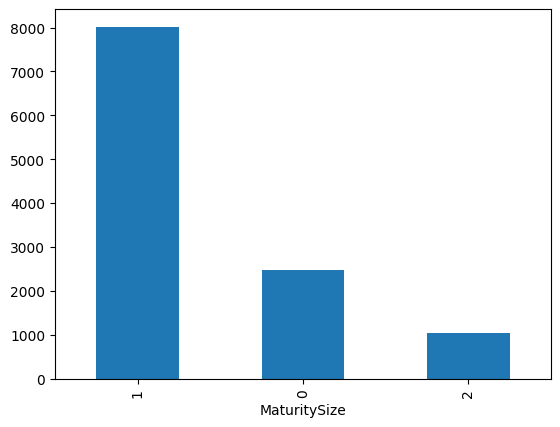

In [173]:
df['MaturitySize'].value_counts().plot(kind='bar')

## FurLength:

In [174]:
df_raw['FurLength'].unique()

array(['Short', 'Medium', 'Long'], dtype=object)

<Axes: xlabel='FurLength'>

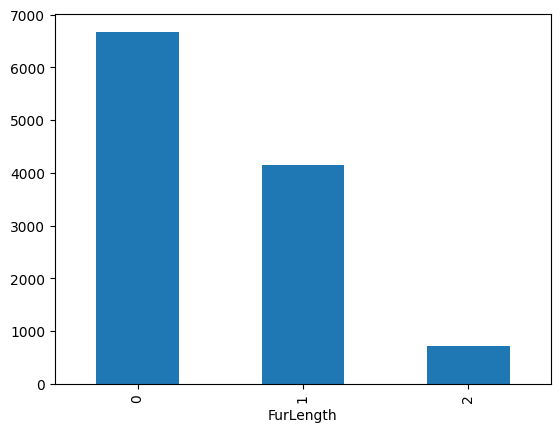

In [175]:
df['FurLength'].value_counts().plot(kind='bar')

## Health:

In [176]:
df_raw['Health'].unique()

array(['Healthy', 'Minor Injury', 'Serious Injury'], dtype=object)

<Axes: xlabel='Health'>

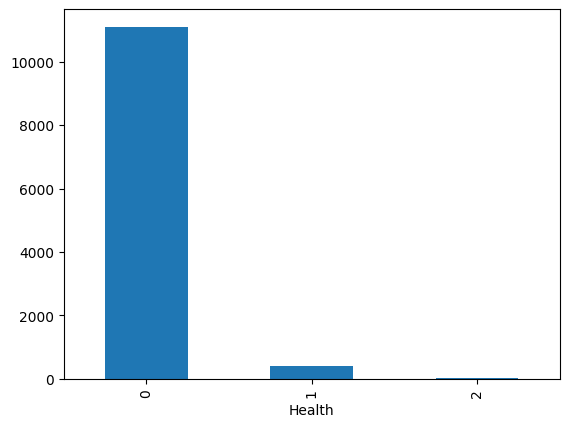

In [177]:
df['Health'].value_counts().plot(kind='bar')

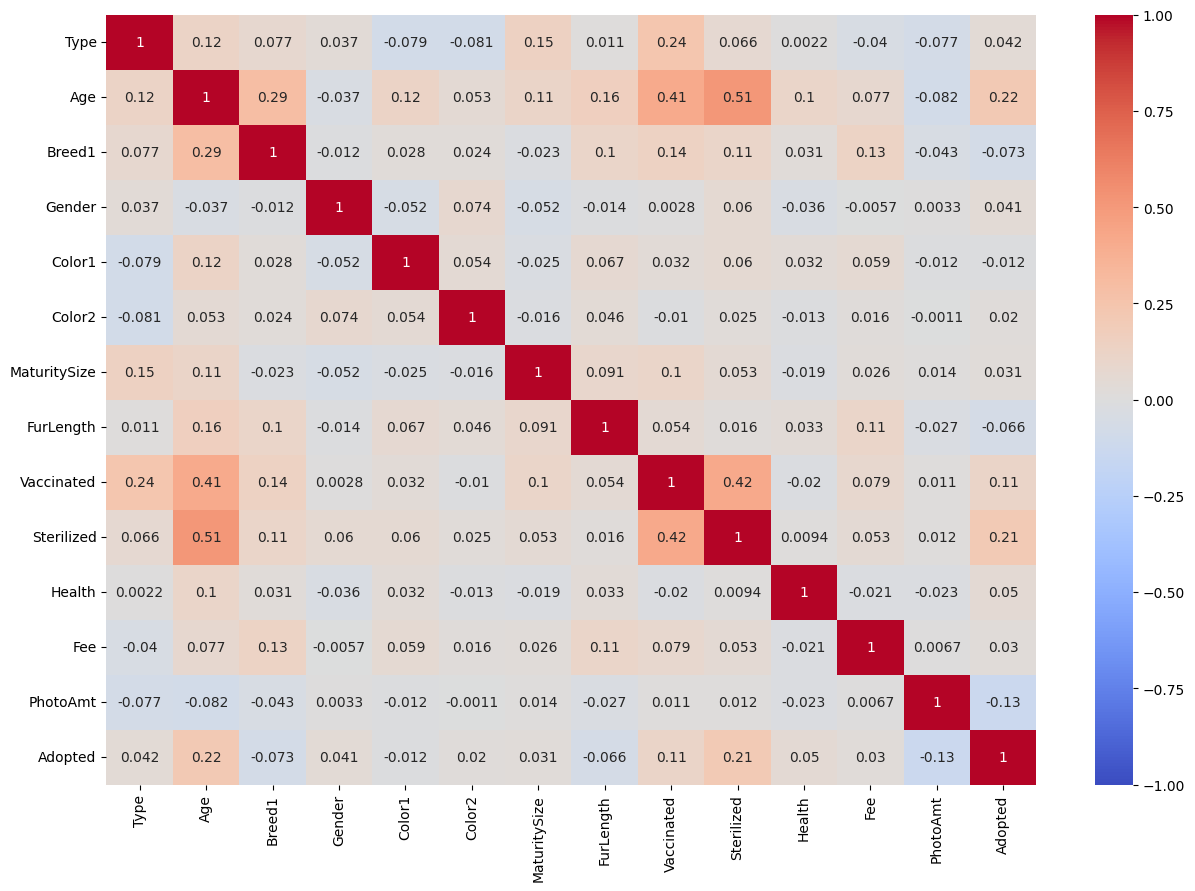

In [178]:
corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


performing dimensionality reduction again after feature transformations

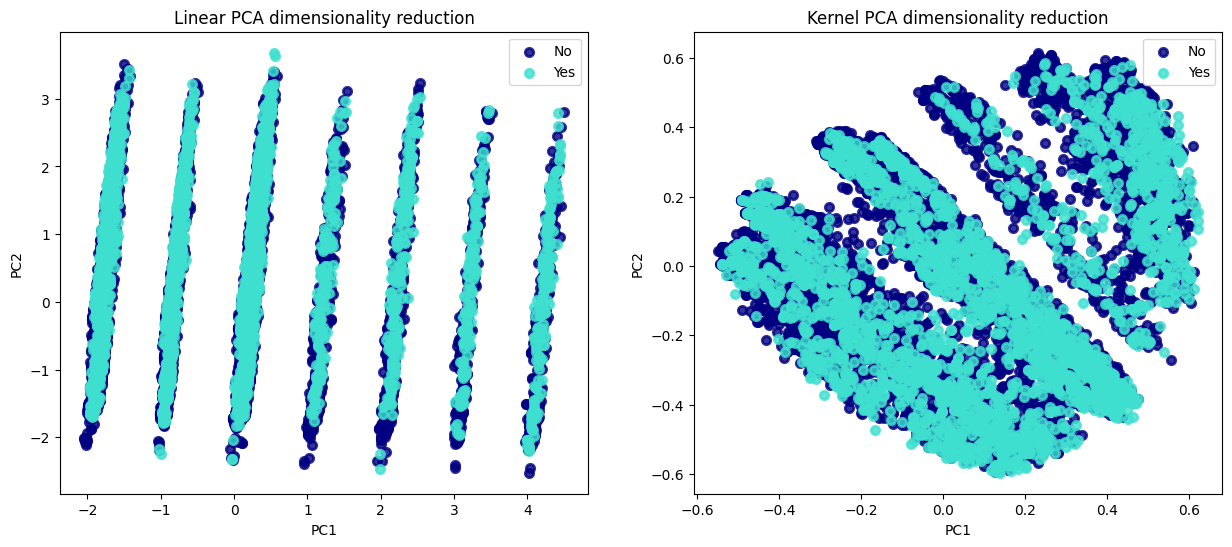

In [179]:
pca = PCA(n_components=2)
kpca = KernelPCA(n_components=2, kernel='rbf')

X_pca = pca.fit_transform(df.drop(['Adopted'], axis=1))
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

X_kpca = kpca.fit_transform(df.drop(['Adopted'], axis=1))
kpca_df = pd.DataFrame(X_kpca, columns=['PC1', 'PC2'])

pca_df['class'] = df['Adopted']
kpca_df['class'] = df['Adopted']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
colors = ['navy', 'turquoise']
lw = 2

for color, i, target_name in zip(colors, [0, 1], ['No', 'Yes']):
    ax1.scatter(pca_df[pca_df['class'] == i]['PC1'], pca_df[pca_df['class'] == i]['PC2'], color=color, alpha=.8, lw=lw, label=target_name)
    ax1.set_title("Linear PCA dimensionality reduction")
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.legend(loc='best', shadow=False, scatterpoints=1)
    ax2.scatter(kpca_df[kpca_df['class'] == i]['PC1'], kpca_df[kpca_df['class'] == i]['PC2'], color=color, alpha=.8, lw=lw, label=target_name)
    ax2.set_title("Kernel PCA dimensionality reduction")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.legend(loc='best', shadow=False, scatterpoints=1)
# Show the plot
plt.show()

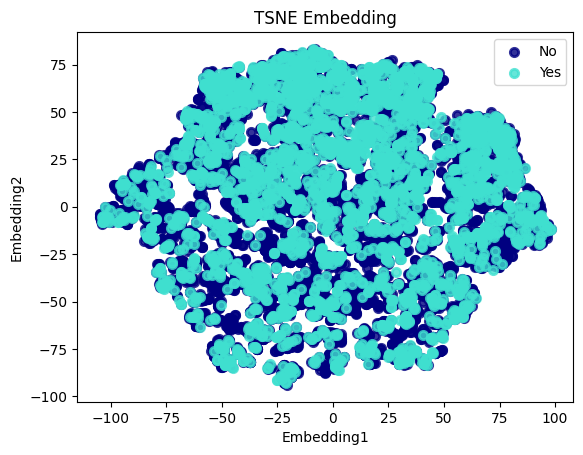

In [180]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(df.drop(['Adopted'], axis=1))
tsne_df = pd.DataFrame(X_tsne, columns=['Embedding1', 'Embedding2'])
tsne_df['class'] = df['Adopted']

fig, ax = plt.subplots()
colors = ['navy', 'turquoise']
lw = 2

for color, i, target_name in zip(colors, [0, 1], ['No', 'Yes']):
    ax.scatter(tsne_df[tsne_df['class'] == i]['Embedding1'], tsne_df[tsne_df['class'] == i]['Embedding2'], color=color, alpha=.8, lw=lw, label=target_name)
ax.set_title("TSNE Embedding")
ax.set_xlabel("Embedding1")
ax.set_ylabel("Embedding2")
ax.legend(loc='best', shadow=False, scatterpoints=1)
# Show the plot
plt.show()


In [181]:
X = df.drop(['Adopted'], axis=1)
y = df['Adopted']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,stratify=y_temp)

In [182]:
y_train.sum()/y_train.shape[0], y_test.sum()/y_test.shape[0], y_val.sum()/y_val.shape[0]

(0.2669748627564288, 0.2668977469670711, 0.2670134373645427)

In [183]:
from sklearn.feature_selection import mutual_info_classif, f_classif, RFE, SelectKBest

mutual_info_classif(X,y)

array([1.63502436e-06, 3.60837495e-02, 1.11655496e-02, 2.20545628e-03,
       0.00000000e+00, 6.77201049e-04, 1.99812078e-04, 0.00000000e+00,
       1.09445151e-02, 2.34285683e-02, 0.00000000e+00, 0.00000000e+00,
       1.25371895e-02])

In [184]:
f_classif(X,y)

(array([ 20.26624633, 575.1803187 ,  61.43978083,  19.39774406,
          1.55827649,   4.56380713,  10.84123118,  50.16662133,
        146.5880322 , 523.61974481,  29.06458232,  10.33780776,
        206.04135338]),
 array([6.80392475e-006, 4.43816087e-124, 4.96575206e-015, 1.07088729e-005,
        2.11943091e-001, 3.26753927e-002, 9.95632789e-004, 1.49444701e-012,
        1.54199587e-033, 2.25854374e-113, 7.13850249e-008, 1.30691741e-003,
        2.51361847e-046]))

# 2. Baseline model:

In [185]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
scale_pos_weight

2.7456709956709955

In [186]:
neg_weight = 1 - sum(y_train == 0)/y_train.shape[0]
pos_weight = 1 - sum(y_train == 1)/y_train.shape[0]
neg_weight, pos_weight

(0.2669748627564288, 0.7330251372435712)

In [187]:
import xgboost as xgb
from xgboost import plot_importance

model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight, early_stopping_rounds=100)
model.fit(X_train, y_train,eval_set=[(X_val,y_val)], verbose=False, sample_weight=np.where(y_train == 0, pos_weight, neg_weight))
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [188]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve, average_precision_score, classification_report

def plot_evaluation_curves(y_test, y_pred_proba):
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = roc_thresholds[optimal_idx]
    y_pred = y_pred_proba > optimal_threshold
    print("Optimal threshold: ", optimal_threshold)

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    average_precision = average_precision_score(y_test, y_pred_proba)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right")

    ax2.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left")
    plt.show()

    return y_pred

Optimal threshold:  0.2399068


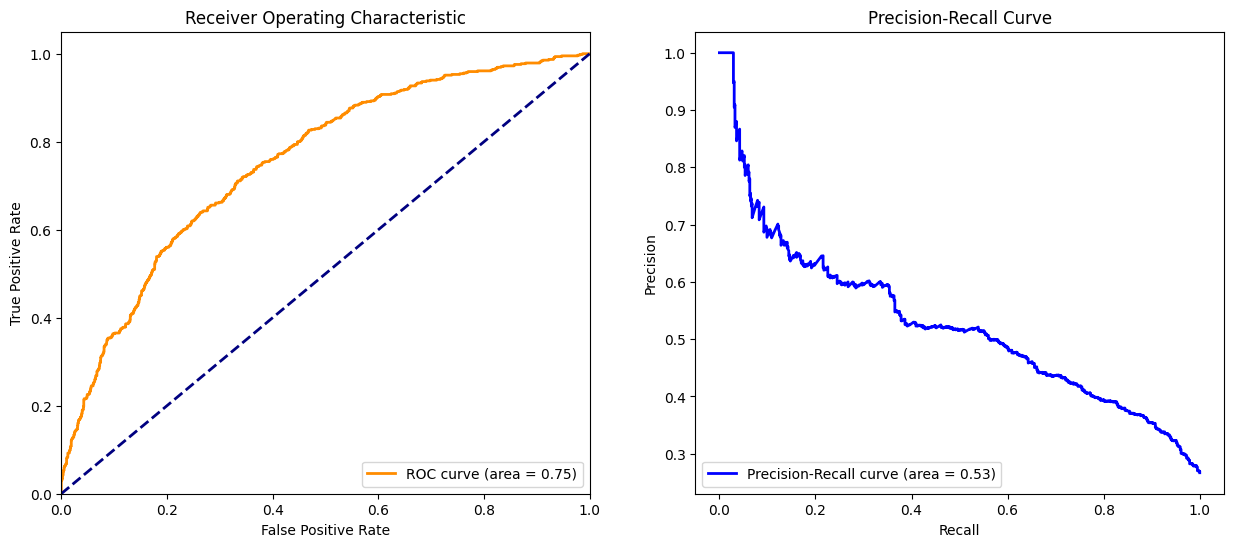

In [189]:
y_pred = plot_evaluation_curves(y_test, y_pred_proba)

In [190]:
from sklearn.metrics import recall_score, f1_score, precision_score, balanced_accuracy_score, confusion_matrix, accuracy_score

def display_summary(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")

    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall * 100:.2f}%")

    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision * 100:.2f}%")

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1 * 100:.2f}%")

    cm = confusion_matrix(y_test, y_pred)
    cm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_test, y_pred))

Accuracy: 67.76%
Balanced Accuracy: 68.77%
Recall: 70.94%
Precision: 43.61%
F1 Score: 54.02%


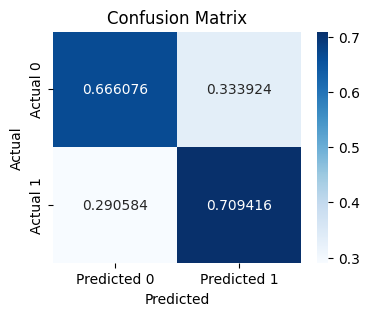

              precision    recall  f1-score   support

           0       0.86      0.67      0.75      1692
           1       0.44      0.71      0.54       616

    accuracy                           0.68      2308
   macro avg       0.65      0.69      0.65      2308
weighted avg       0.75      0.68      0.70      2308



In [191]:
display_summary(y_test, y_pred)

# 3. Catboost:

In [192]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(class_weights={0: neg_weight, 1: pos_weight}, verbose=100)
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

Learning rate set to 0.051103
0:	learn: 0.6844647	test: 0.6844785	best: 0.6844785 (0)	total: 2.75ms	remaining: 2.75s
100:	learn: 0.5357728	test: 0.5761648	best: 0.5760200 (99)	total: 272ms	remaining: 2.42s
200:	learn: 0.5003655	test: 0.5740863	best: 0.5740863 (200)	total: 575ms	remaining: 2.28s
300:	learn: 0.4720814	test: 0.5755998	best: 0.5733674 (215)	total: 847ms	remaining: 1.97s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5733673793
bestIteration = 215

Shrink model to first 216 iterations.


Optimal threshold:  0.4400058465268501


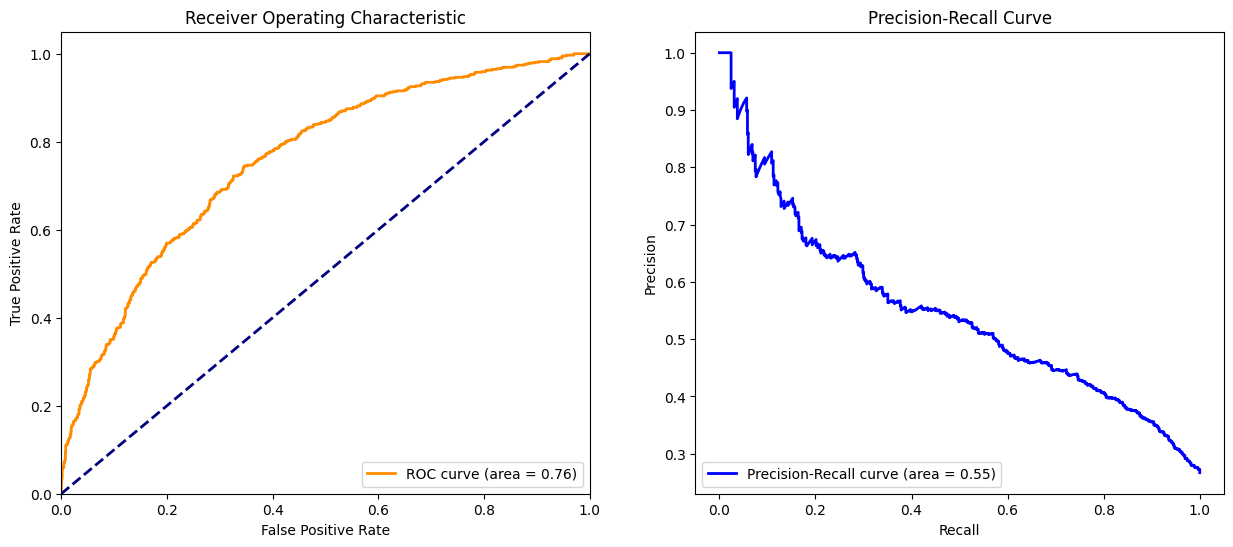

In [193]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = plot_evaluation_curves(y_test, y_pred_proba)

Accuracy: 67.76%
Balanced Accuracy: 69.86%
Recall: 74.35%
Precision: 43.87%
F1 Score: 55.18%


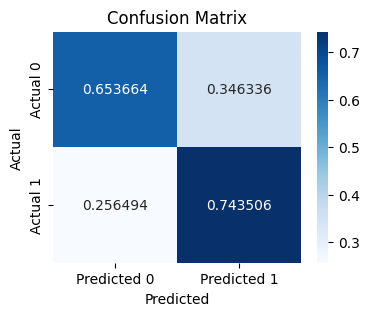

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      1692
           1       0.44      0.74      0.55       616

    accuracy                           0.68      2308
   macro avg       0.66      0.70      0.65      2308
weighted avg       0.76      0.68      0.70      2308



In [194]:
display_summary(y_test, y_pred)

 99%|===================| 2282/2308 [00:27<00:00]        

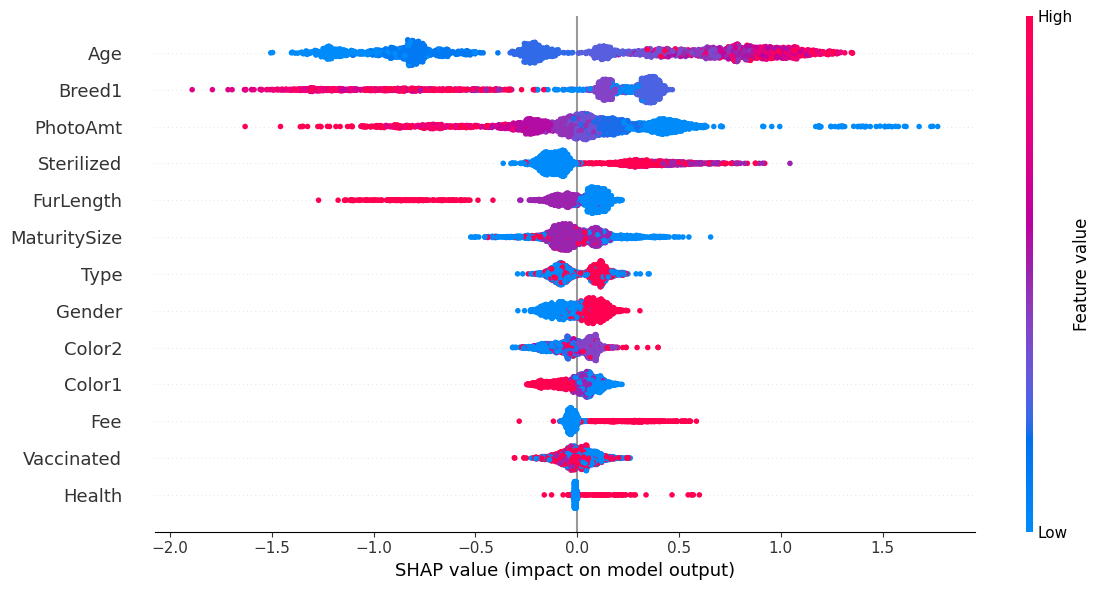

In [195]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test, show=False, plot_size=None)
plt.show()

# 4. Oversampling + xgboost:

In [196]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='all')
sampled_X_train, sampled_y_train = smote.fit_resample(X_train, y_train)

# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=42)
# X_train, y_train = rus.fit_resample(X_train, y_train)

In [197]:
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', early_stopping_rounds=100)
model.fit(sampled_X_train, sampled_y_train,eval_set=[(X_val,y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Optimal threshold:  0.2927084


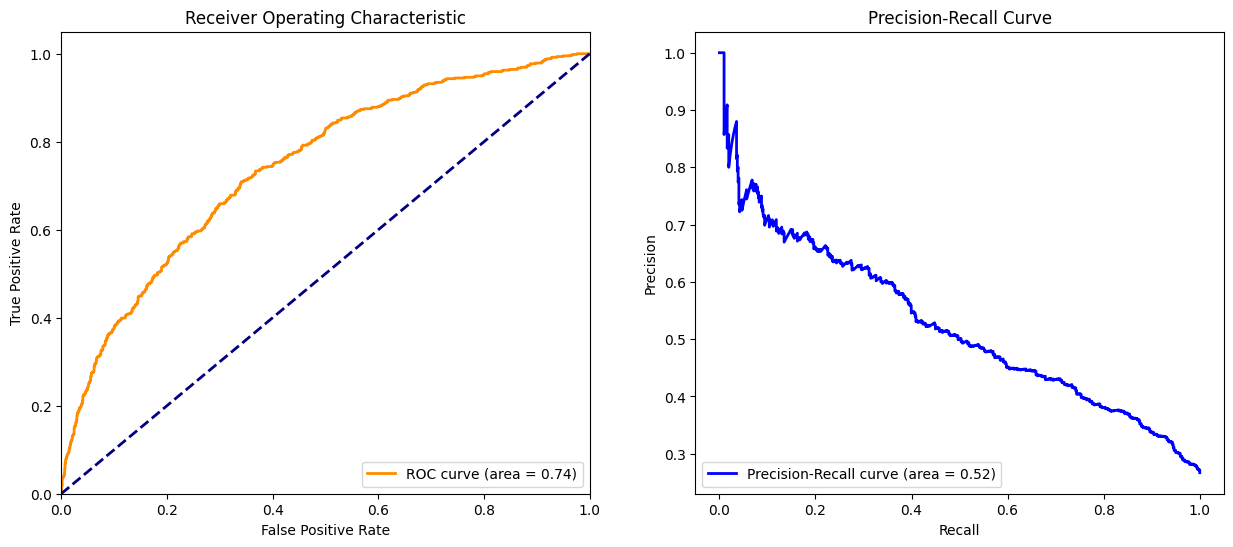

In [198]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = plot_evaluation_curves(y_test, y_pred_proba)

Accuracy: 67.20%
Balanced Accuracy: 68.34%
Recall: 70.78%
Precision: 43.04%
F1 Score: 53.53%


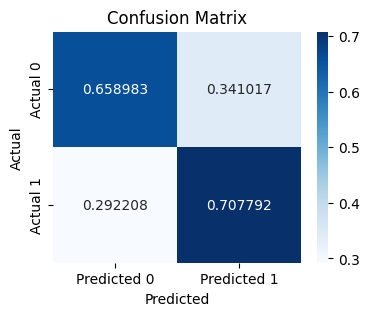

              precision    recall  f1-score   support

           0       0.86      0.66      0.75      1692
           1       0.43      0.71      0.54       616

    accuracy                           0.67      2308
   macro avg       0.65      0.68      0.64      2308
weighted avg       0.75      0.67      0.69      2308



In [199]:
display_summary(y_test, y_pred)

# 5. Oversampling + Catboost:

In [200]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(verbose=100)
model.fit(sampled_X_train, sampled_y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

Learning rate set to 0.056167
0:	learn: 0.6793899	test: 0.6802581	best: 0.6802581 (0)	total: 8.1ms	remaining: 8.09s
100:	learn: 0.4222464	test: 0.5233576	best: 0.5233576 (100)	total: 542ms	remaining: 4.83s
200:	learn: 0.3759297	test: 0.5100576	best: 0.5100576 (200)	total: 1.1s	remaining: 4.38s
300:	learn: 0.3420494	test: 0.5029867	best: 0.5029648 (299)	total: 1.68s	remaining: 3.89s
400:	learn: 0.3209967	test: 0.5018508	best: 0.5018508 (400)	total: 2.23s	remaining: 3.33s
500:	learn: 0.3046847	test: 0.5028757	best: 0.5015671 (416)	total: 2.76s	remaining: 2.75s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5015670973
bestIteration = 416

Shrink model to first 417 iterations.


Optimal threshold:  0.29388855007514103


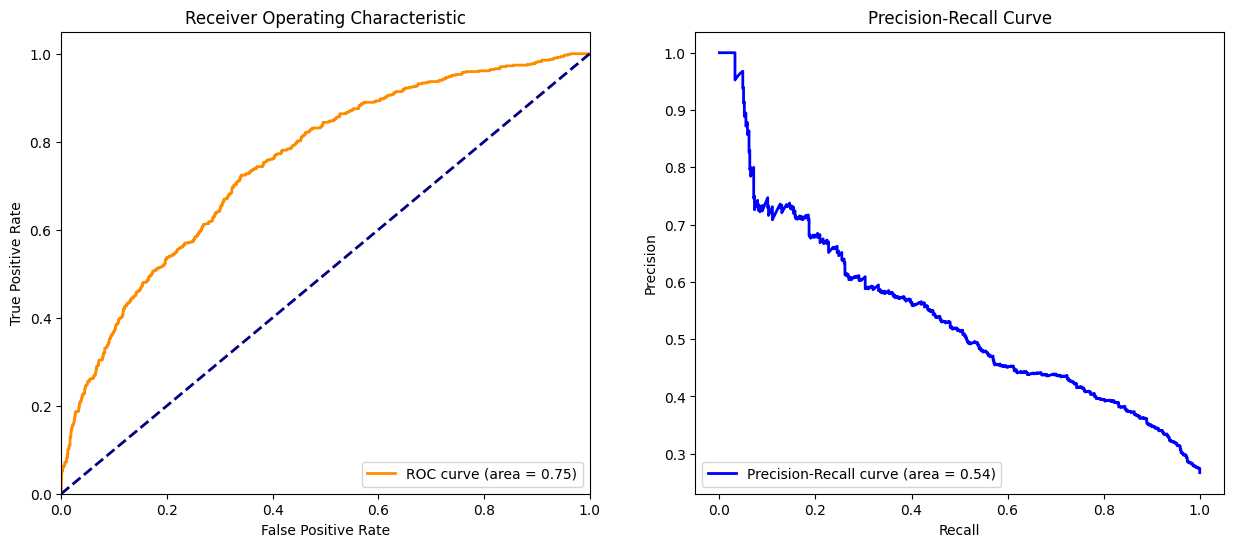

In [201]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = plot_evaluation_curves(y_test, y_pred_proba)


Accuracy: 67.63%
Balanced Accuracy: 69.10%
Recall: 72.24%
Precision: 43.58%
F1 Score: 54.37%


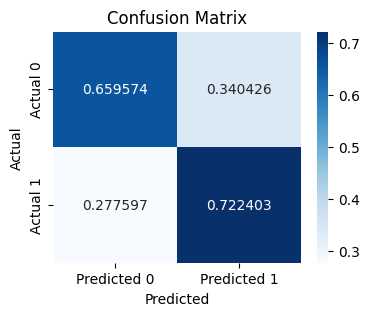

              precision    recall  f1-score   support

           0       0.87      0.66      0.75      1692
           1       0.44      0.72      0.54       616

    accuracy                           0.68      2308
   macro avg       0.65      0.69      0.65      2308
weighted avg       0.75      0.68      0.69      2308



In [202]:
display_summary(y_test, y_pred)

# 6. RFE + XGboost:

In [203]:
def select_features(model, n_features = 5):
    selector = RFE(model, n_features_to_select=n_features)
    selector = selector.fit(X_train, y_train)
    selected_X_train = X_train.loc[:, selector.support_]
    selected_X_val = X_val.loc[:, selector.support_]
    selected_X_test = X_test.loc[:, selector.support_]
    print("Selected features: ", selected_X_train.columns)
    return selected_X_train, selected_X_test, selected_X_val

In [204]:
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight)

In [205]:
selected_X_train, selected_X_test, selected_X_val = select_features(model)

Selected features:  Index(['Type', 'Age', 'Breed1', 'Sterilized', 'PhotoAmt'], dtype='object')


In [206]:
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight, early_stopping_rounds=100)
model.fit(selected_X_train, y_train,eval_set=[(selected_X_val,y_val)], verbose=False, sample_weight=np.where(y_train == 0, pos_weight, neg_weight))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Optimal threshold:  0.2365548


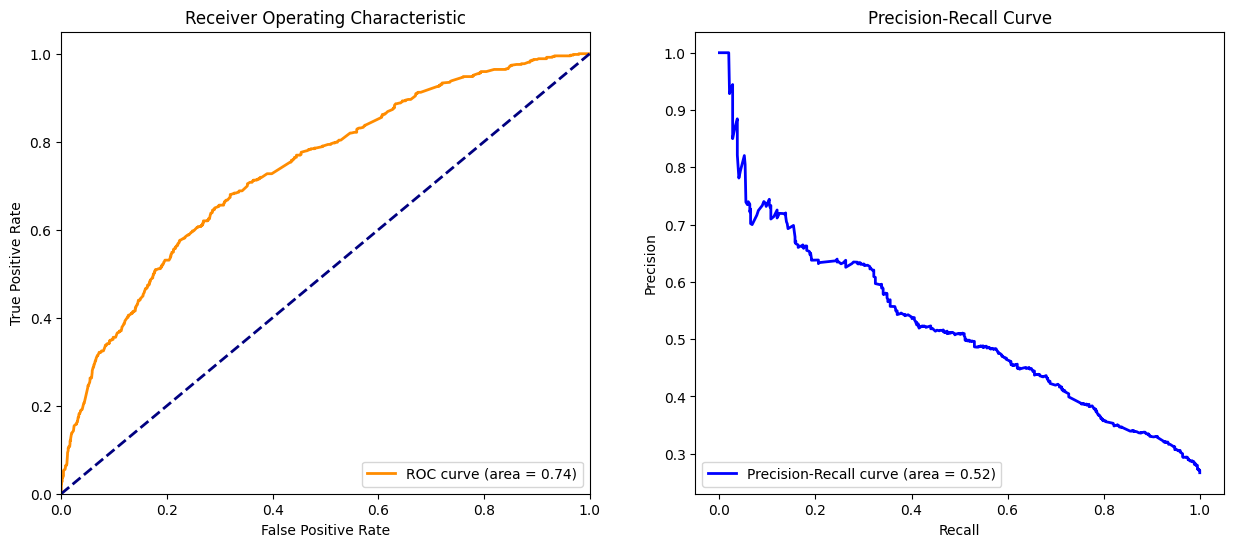

In [207]:
y_pred_proba = model.predict_proba(selected_X_test)[:, 1]
y_pred = plot_evaluation_curves(y_test, y_pred_proba)


Accuracy: 67.94%
Balanced Accuracy: 67.86%
Recall: 67.69%
Precision: 43.53%
F1 Score: 52.99%


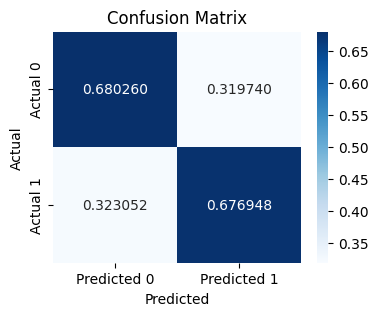

              precision    recall  f1-score   support

           0       0.85      0.68      0.76      1692
           1       0.44      0.68      0.53       616

    accuracy                           0.68      2308
   macro avg       0.64      0.68      0.64      2308
weighted avg       0.74      0.68      0.70      2308



In [208]:
display_summary(y_test, y_pred)

# 7. RFE + Catboost:

In [209]:
model = CatBoostClassifier(class_weights={0: neg_weight, 1: pos_weight}, verbose=0)

In [210]:
selected_X_train, selected_X_test, selected_X_val = select_features(model)

Selected features:  Index(['Age', 'Breed1', 'Color2', 'Sterilized', 'PhotoAmt'], dtype='object')


In [211]:
model = CatBoostClassifier(class_weights={0: neg_weight, 1: pos_weight}, verbose=100)
model.fit(selected_X_train, y_train, eval_set=(selected_X_val, y_val), early_stopping_rounds=100)

Learning rate set to 0.051103
0:	learn: 0.6841869	test: 0.6845423	best: 0.6845423 (0)	total: 3.01ms	remaining: 3.01s
100:	learn: 0.5618178	test: 0.5903605	best: 0.5902720 (96)	total: 307ms	remaining: 2.73s
200:	learn: 0.5395911	test: 0.5898183	best: 0.5884955 (161)	total: 598ms	remaining: 2.38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5884955348
bestIteration = 161

Shrink model to first 162 iterations.


Optimal threshold:  0.4498406350921688


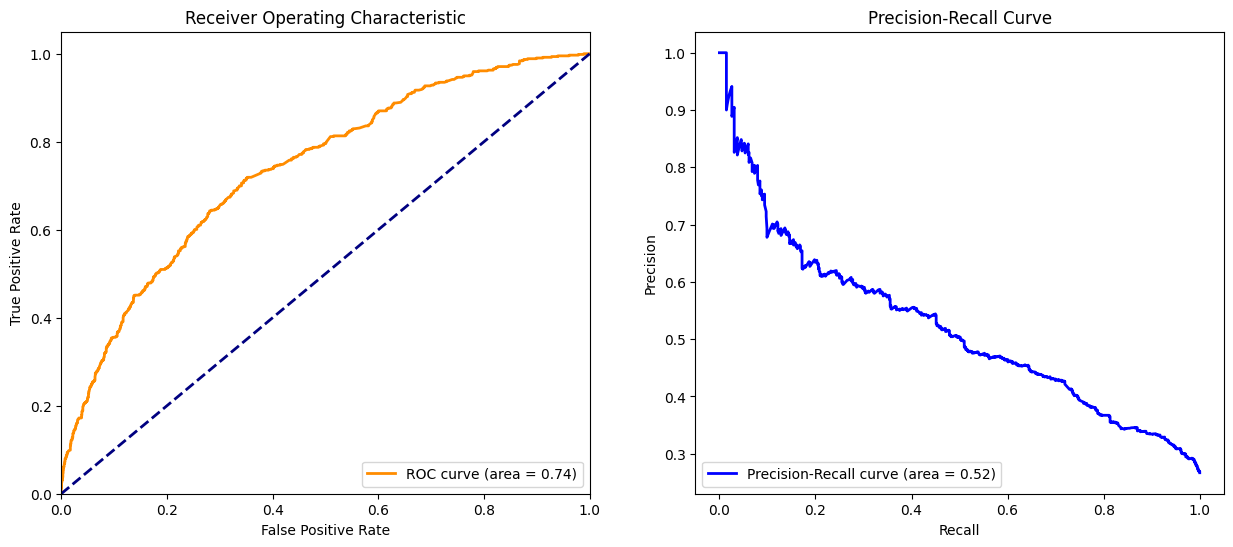

In [212]:
y_pred_proba = model.predict_proba(selected_X_test)[:, 1]
y_pred = plot_evaluation_curves(y_test, y_pred_proba)


Accuracy: 66.72%
Balanced Accuracy: 68.27%
Recall: 71.59%
Precision: 42.65%
F1 Score: 53.45%


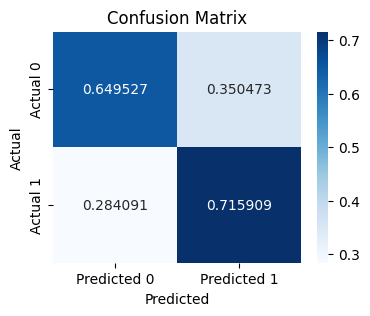

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      1692
           1       0.43      0.72      0.53       616

    accuracy                           0.67      2308
   macro avg       0.64      0.68      0.64      2308
weighted avg       0.75      0.67      0.69      2308



In [213]:
display_summary(y_test, y_pred)

In [214]:
# def custom_objective(y_true, y_pred):
#     # Transform predictions to probabilities
#     y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
#     y_pred = 1.0 / (1.0 + np.exp(-y_pred))
#     # # Gradient
#     # grad = y_pred - 0.36*y_true
#     # # Hessian
#     # hess = y_pred * (1.0 - y_pred)
#     # p = -np.mean(0.36 * y_true * np.log(y_pred) + 0.64 * (1 - y_true) * np.log(1 - y_pred))
#     grad = - ((0.36 * y_true) / y_pred) + (0.64 * (1 - y_true)) / (1 - y_pred)
#     hess = ((0.36*y_true) / (y_pred ** 2)) + (0.64*(1 - y_true)) / ((1 - y_pred) ** 2)
#     return grad, hess